In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
movie_df = pickle.load(open('clean_movie_df.pickle', 'rb'))

In [3]:
movie_df.release = pd.to_datetime(movie_df.release)
movie_df[movie_df.release >= dt.datetime(2019,1,1)].budget.isna().value_counts()

False    113
True      76
Name: budget, dtype: int64

In [4]:
#read holidays csv
holidays = pd.read_csv('usholidays.csv')

#convert all dates to datetime/timestamp
movie_df.release = pd.to_datetime(movie_df.release)
holidays.loc[:,'Date'] = pd.to_datetime(holidays.Date)

#filter out holiday dates before the year 2000
holidays = holidays[holidays.Date >= dt.datetime(2000,1,1)].Date

#########################IF I have Time: Try to replace this with numpy array combinations
def find_closest_holiday(date):
    """
    Finds the days to the nearest US Federal Holiday
    args:
    date (timestamp)
    returns:
    nearest_hol (int) days to the nearest holiday
    """
    nearest_hol = 365
    for hol in holidays:
        d = abs((hol - date).days)
        if d < nearest_hol:
            nearest_hol = d
    return nearest_hol

movie_df['holiday_distance'] = movie_df.release.map(find_closest_holiday)
#movie_df.drop(columns='release', inplace=True)

In [5]:
movie_df['year'] = movie_df.release.map(lambda x: x.year-2000)

In [6]:
movie_df.rename(columns={'index':'title'}, inplace=True)

In [7]:
#looking for movies with more than 1 director
#shows a small subset
movie_df.Director[movie_df.Director.str.split(pat=',').map(len)>2]

3909    Frank Miller, Quentin Tarantino, Robert Rodriguez
508      Alastair Fothergill, Keith Scholey, Adam Chapman
1853    Robert Rodriguez, Eli Roth, Quentin Tarantino,...
4019        Bob Persichetti, Peter Ramsey, Rodney Rothman
2042               Cory Edwards, Todd Edwards, Tony Leech
1439               Jeff Schaffer, Alec Berg, David Mandel
1278         Dave Borthwick, Jean Duval, Frank Passingham
1475    James Algar, Gaëtan Brizzi, Paul Brizzi, Hende...
2990    Elizabeth Banks, Steven Brill, Steve Carr, Rus...
1912    Paul Bolger, Yvette Kaplan, Greg Tiernan, Dino...
743           Mark Andrews, Brenda Chapman, Steve Purcell
1208              Kyle Balda, Pierre Coffin, Eric Guillon
2721             Eric Darnell, Tom McGrath, Conrad Vernon
5251          Bibo Bergeron, Don Paul, Jeffrey Katzenberg
6018                 Byron Howard, Rich Moore, Jared Bush
3874          Andrew Adamson, Kelly Asbury, Conrad Vernon
4375    Anna Chi, Daniel Chuba, Mark A.Z. Dippé, Wonja...
1918          

In [8]:
columns_to_count = ['Director', 
                    'distr', 
                    'Composer', 
                    'Cinematographer', 
                    'Editor', 
                    'Production Designer', 
                    'Writer', 
                    'Producer', 
                    'Actors']
#Gets number of times the crewmember or distributor works on something in the dataframe.  
#Larger n may associate with more experience
for crew in columns_to_count:
    
    """########### portfolios really have little to no correlation with gross_dom target
    ########### But the portfolio value is useful for determining how to fill nulls
    curr_portfolio = movie_df[crew].value_counts().reset_index()
    curr_portfolio = pd.DataFrame(curr_portfolio).rename(columns={'index':crew, crew:crew+'_portfolio'})
    movie_df = movie_df.merge(curr_portfolio, left_on=crew, right_on=crew)"""
    
    # Some movies have multiple people in the same row.  Split them to get their individual average amounts 
    curr = movie_df[['title', crew]]
    
    # make list to append unique title/name combination
    curr_crew = []
    for row in range(len(curr)):
        movietitle = curr.iloc[row][0]
        try:
            for name in curr.iloc[row][1].split(','):
                name = name.strip()
                curr_crew.append((movietitle, name))
        except:
            pass
    curr_crew = pd.DataFrame(curr_crew, columns=['title', crew])
    curr_crew.drop_duplicates(inplace=True)
    
    curr_crew=curr_crew.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], on='title')
    
    # remove null or nan quantities
    curr_crew.set_index(crew, inplace=True)
    try:
        curr_crew = curr_crew.drop('nan').reset_index()
    except:
        curr_crew = curr_crew.reset_index()
    
    # get count of total times the crew shows up
    crew_counts = curr_crew[crew].value_counts()

    # sort alphabetically to group the crew members
    # then sort by release date to put them in order
    curr_crew = curr_crew.sort_values(by=[crew, 'release'])
    unique_members = curr_crew[crew].unique()
    
    prev = []
    prev_gross_dom = []
    prev_budget = []
    for name in unique_members:
        # generate list with number of times the crew member has shown up prior to the current row (Since 2000)
        prev.extend([x for x in range(crew_counts.loc[name])])
        # create slices based on position and get sum of previous iterations to get cumulative sum prior to current movie
        for c in range(crew_counts.loc[name]):
            pg = curr_crew[curr_crew[crew]==name][:c]['gross_dom'].sum()
            pb = curr_crew[curr_crew[crew]==name][:c]['budget'].sum()
            prev_gross_dom.append(pg)
            prev_budget.append(pb)
    
    # add each of the above lists as columns on the curr_crew df
    curr_crew['n_previous'] = prev
    curr_crew['previous_cumulative_domestic'] = prev_gross_dom
    curr_crew['previous_cumulative_budget'] = prev_budget
    
    curr_crew.reset_index(drop=True, inplace=True)
    

    # get the crew's prior average
    curr_crew['average_prior_{}_dom'.format(crew)] = curr_crew['previous_cumulative_domestic']/curr_crew['n_previous']
    curr_crew['average_prior_{}_budget'.format(crew)] = curr_crew['previous_cumulative_budget']/curr_crew['n_previous']
    
    # divide by zero error (no prior history)
    curr_crew['average_prior_{}_dom'.format(crew)].fillna(value=0, inplace=True)
    curr_crew['average_prior_{}_budget'.format(crew)].fillna(value=0, inplace=True)
    
    # Averages the writer's prior averages who share the same movie title
    curr_crew = curr_crew.groupby('title', as_index=False).aggregate({'average_prior_{}_dom'.format(crew): 'mean', 'average_prior_{}_budget'.format(crew): 'mean'})
    # merge movie_df and curr_crew
    # how='left' to presrve values from the left df (movie_df) and fills in nans 
    movie_df = movie_df.merge(curr_crew, on='title', how='left')

    

In [9]:
movie_df.isnull().sum()

title                                         0
link_stub                                     0
release                                       0
theaters                                      0
desc                                          0
distr                                        60
opening                                     571
budget                                      962
mpaa                                        147
runtime                                      23
genres                                        0
gross_dom                                     0
gross_inter                                   0
gross_world                                 163
Director                                      0
Writer                                        0
Producer                                      0
Composer                                      0
Cinematographer                               0
Editor                                        0
Production Designer                     

In [10]:
len(movie_df.Director.unique())

1609

In [11]:
movie_df.corrwith(movie_df.gross_dom).sort_values(ascending=False)

gross_dom                                   1.000000
gross_world                                 0.943116
opening                                     0.942937
gross_inter                                 0.865820
budget                                      0.654337
average_prior_Producer_dom                  0.533900
average_prior_Producer_budget               0.479496
average_prior_Writer_dom                    0.473330
average_prior_Writer_budget                 0.421606
average_prior_Editor_dom                    0.413389
average_prior_distr_dom                     0.409444
average_prior_Director_dom                  0.402956
average_prior_Composer_dom                  0.402932
average_prior_Production Designer_budget    0.399918
average_prior_distr_budget                  0.386244
average_prior_Composer_budget               0.381488
average_prior_Production Designer_dom       0.371196
average_prior_Director_budget               0.363902
average_prior_Editor_budget                 0.

In [12]:
movie_df.holiday_distance[0]

39

# Deal with nan

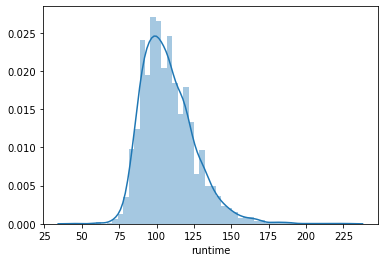

In [13]:
# fill runtime nans with average/mean
sns.distplot(movie_df.runtime)

In [14]:
# fill na with median
movie_df.runtime.fillna(value=movie_df.runtime.median(), inplace=True)

In [16]:
movie_df.columns

Index(['title', 'link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'mpaa', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'average_prior_Director_dom',
       'average_prior_Director_budget', 'average_prior_distr_dom',
       'average_prior_distr_budget', 'average_prior_Composer_dom',
       'average_prior_Composer_budget', 'average_prior_Cinematographer_dom',
       'average_prior_Cinematographer_budget', 'average_prior_Editor_dom',
       'average_prior_Editor_budget', 'average_prior_Production Designer_dom',
       'average_prior_Production Designer_budget', 'average_prior_Writer_dom',
       'average_prior_Writer_budget', 'average_prior_Producer_dom',
       'average_prior_Producer_budget', 'average_prior_Actors_dom',
       'average_prior_Actors_budget'],
      dtype='object')

In [50]:
movie_df.isnull().sum()

title                                         0
link_stub                                     0
release                                       0
theaters                                      0
desc                                          0
distr                                        60
opening                                     571
budget                                        0
mpaa                                        147
runtime                                       0
genres                                        0
gross_dom                                     0
gross_inter                                   0
gross_world                                 163
Director                                      0
Writer                                        0
Producer                                      0
Composer                                      0
Cinematographer                               0
Editor                                        0
Production Designer                     

In [36]:
np.log(1)

0.0

In [49]:
# if the row has a null value for the budget
# the average budget of the crew/distr should reflect the overall budget as well



budget_list = ['average_prior_Director_budget',
       'average_prior_distr_budget',
       'average_prior_Composer_budget',
       'average_prior_Cinematographer_budget',
       'average_prior_Editor_budget',
       'average_prior_Production Designer_budget',
       'average_prior_Writer_budget',
       'average_prior_Producer_budget',
       'average_prior_Actors_budget']
for each in budget_list:
    movie_df[each] = movie_df[each].map(lambda x: 0 if str(x)=='nan' else x)
    
movie_df['average_row_budget'] = np.mean(movie_df[['budget', 'average_prior_Director_budget',
       'average_prior_distr_budget',
       'average_prior_Composer_budget',
       'average_prior_Cinematographer_budget',
       'average_prior_Editor_budget',
       'average_prior_Production Designer_budget',
       'average_prior_Writer_budget',
       'average_prior_Producer_budget',
       'average_prior_Actors_budget']], axis=1)
movie_df.budget.fillna(value=movie_df.average_row_budget, axis=0, inplace=True)


In [51]:
movie_df['day_of_year'] = movie_df.release.map(lambda x : x.dayofyear)

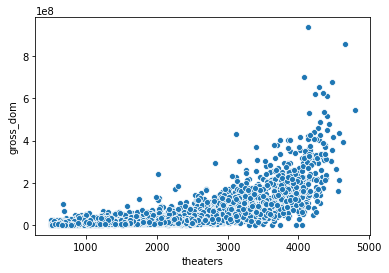

In [52]:
# theaters and gross_dom have a logistic relationship
sns.scatterplot(x='theaters', y='gross_dom', data=movie_df);

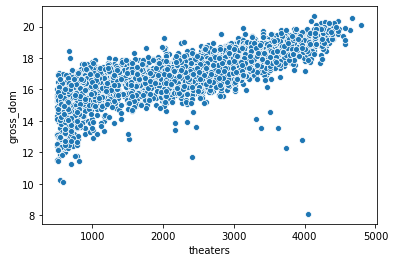

In [53]:
# log(y) = x looks linear
sns.scatterplot(x=movie_df.theaters, y=movie_df.gross_dom.map(np.log))

In [54]:
# standardize theaters value and raise to the exponent
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
movie_df.theaters = scaler.fit_transform(movie_df[['theaters']])
movie_df['theaters_exp'] = movie_df.theaters.map(np.exp)

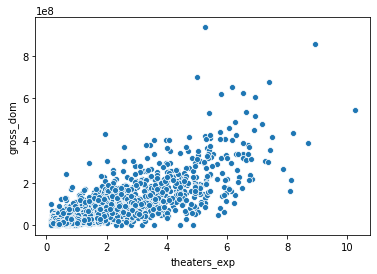

In [55]:
sns.scatterplot(x='theaters_exp', y='gross_dom', data=movie_df)

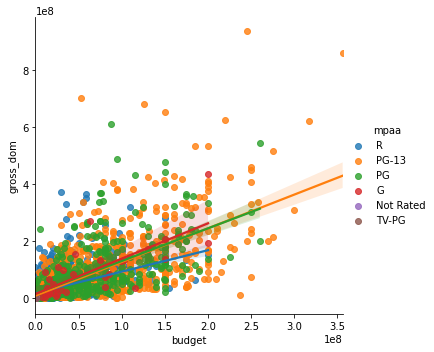

In [56]:
sns.lmplot(x='budget', y='gross_dom', data=movie_df, hue='mpaa')

In [57]:
#get median values for distr in nan opening
med_nan_dict = {i : movie_df[movie_df.distr==i].opening.median() for i in movie_df.distr.unique()}
 

for idx, o in enumerate(movie_df.opening): 
    if np.isnan(o):
        key = movie_df.distr.iloc[idx]
        movie_df.opening.iloc[idx] = med_nan_dict[key]

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
# group day of year, budget, runtime into categories
# day of year
# Winter - Dec 21 to March 20 -- 355, 79
# Spring - March 20 to June 20 -- 79, 171
# Summer - June 20 to September 22 171, 265
# Fall - September 22 to Dec 21 265, 355
# Budget 
# Low < 29092651
# 29092651 < Medium < 52000000
# 52000000 < High
# Runtime
# Short < 60
# Normal < 60-120
# Long > 120

In [59]:
def seasons(day):
    if day < 79 or day > 355:
        return 'winter'
    elif day < 171:
        return 'spring'
    elif day < 265:
        return 'summer'
    else:
        return 'fall'
    
def budget_quality(bud):
    if bud < 29092651: #33 quantile
        return 'low'
    elif bud > 52000000: #66 quantile
        return 'high'
    else:
        return 'medium'

def runtime_quality(r):
    if r < 90:
        return 'short'
    elif r > 120:
        return 'long'
    else:
        return 'normal'
    
movie_df['seasons'] = movie_df.day_of_year.map(seasons)
movie_df['budget_cat'] = movie_df.budget.map(budget_quality)
movie_df['runtime_cat'] = movie_df.runtime.map(runtime_quality)

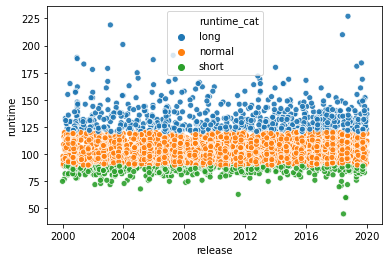

In [60]:
sns.scatterplot(x='release', y='runtime', data=movie_df, hue='runtime_cat', alpha=0.9)

In [26]:
# Generate Target of ROI
# movie_df['roi'] = (movie_df.gross_dom-movie_df.budget)/movie_df.budget

# Movie Genre and MPAA Dummies

In [61]:
def dumdumdum(movie_df):
    #get dummies for genres
    movie_df.set_index('title', inplace=True)
    movie_df = movie_df.merge(movie_df.genres.str.get_dummies(sep=', '), left_index=True, right_index=True, );
    
    #get dummies for mpaa rating
    movie_df = pd.get_dummies(movie_df, columns=['mpaa', 'seasons', 'budget_cat', 'runtime_cat'], drop_first=False)
    return movie_df

movie_df = movie_df.dropna(axis=0)
movie_df = dumdumdum(movie_df)

In [62]:
prepped = movie_df
with open('processed_movie_df.pickle', 'wb') as to_write:
    pickle.dump(prepped, to_write)

In [30]:
movie_df.columns

Index(['link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'average_prior_Director_dom',
       'average_prior_Director_budget', 'average_prior_distr_dom',
       'average_prior_distr_budget', 'average_prior_Composer_dom',
       'average_prior_Composer_budget', 'average_prior_Cinematographer_dom',
       'average_prior_Cinematographer_budget', 'average_prior_Editor_dom',
       'average_prior_Editor_budget', 'average_prior_Production Designer_dom',
       'average_prior_Production Designer_budget', 'average_prior_Writer_dom',
       'average_prior_Writer_budget', 'average_prior_Producer_dom',
       'average_prior_Producer_budget', 'average_prior_Actors_dom',
       'average_prior_Actors_budget', 'average_row_budget', 'day_of_year',
      

In [34]:
movie_df.runtime.describe().min() < 60

True

In [35]:
movie_df.roi.describe()

count    2890.000000
mean        3.288855
std       133.915431
min        -0.996656
25%        -0.508387
50%         0.000677
75%         0.844988
max      7193.587333
Name: roi, dtype: float64

In [36]:
movie_df.loc[movie_df.roi==movie_df.roi.max()]

,link_stub,release,theaters,desc,distr,opening,budget,runtime,genres,gross_dom,...,seasons_fall,seasons_spring,seasons_summer,seasons_winter,budget_cat_high,budget_cat_low,budget_cat_medium,runtime_cat_long,runtime_cat_normal,runtime_cat_short
title,,,,,,,,,,,,,,,,,,,,,
Paranormal Activity,/release/rl2355725825/?ref_=bo_yld_table_30,2009-09-25,0.243259,"After moving into a suburban home, a couple be...",Paramount Pictures,15451981.0,15000.0,86.0,"Horror, Mystery",107918810,...,1,0,0,0,0,1,0,0,0,1


In [37]:
movie_df.corrwith(movie_df.roi).sort_values(ascending=False).head(10)

roi                          1.000000
runtime_cat_short            0.057669
Horror                       0.056905
Mystery                      0.051346
budget_cat_low               0.034928
seasons_fall                 0.028915
mpaa_R                       0.025454
gross_dom_Actors             0.021707
gross_dom_Cinematographer    0.019851
gross_dom_Editor             0.016520
dtype: float64

In [38]:
begin_columns = begin_columns.values

NameError: name 'begin_columns' is not defined

In [ ]:
begin_columns = np.append(begin_columns, 'roi')

In [ ]:
sns.pairplot(movie_df[movie_df.roi<5][begin_columns])

In [ ]:
begin_columns = begin_columns.tolist()

In [ ]:
begin_columns[0] = 'title'

In [ ]:
movie_df.columns

In [ ]:
sns.boxplot(movie_df.gross_dom)

In [ ]:
movie_df[movie_df.gross_dom>2.5e8].describe()

In [ ]:
movie_df.head()

In [35]:
curr=movie_df[['title','Writer']]


In [36]:
curr_crew = []
for row in range(len(curr)):
    movietitle = curr.iloc[row][0]
    try:
        for name in curr.iloc[row][1].split(','):
            name = name.strip()
            curr_crew.append((movietitle, name))
    except:
        pass
curr_crew = pd.DataFrame(curr_crew, columns=['title', 'Writer'])

In [37]:
curr_crew.drop_duplicates(inplace=True)
curr_crew=curr_crew.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], on='title')

In [38]:
# remove null or nan quantities
curr_crew.set_index('Writer', inplace=True)
curr_crew = curr_crew.drop('nan').reset_index()



In [39]:
# get count of total times the crew shows up
crew_counts = curr_crew.Writer.value_counts()

In [40]:
# sort alphabetically to group the crew members
# then sort by release date to put them in order
curr_crew = curr_crew.sort_values(by=['Writer', 'release'])
unique_writers = curr_crew.Writer.unique()

In [41]:
prev = []
prev_gross_dom = []
prev_budget = []
for name in unique_writers:
    # generate list with number of times the crew member has shown up prior to the current row (Since 2000)
    prev.extend([x for x in range(crew_counts.loc[name])])
    # create slices based on position and get sum of previous iterations to get cumulative sum prior to current movie
    for c in range(crew_counts.loc[name]):
        pg = curr_crew[curr_crew.Writer==name][:c]['gross_dom'].sum()
        pb = curr_crew[curr_crew.Writer==name][:c]['budget'].sum()
        prev_gross_dom.append(pg)
        prev_budget.append(pb)

In [42]:
# add each of the above rows as columns on the curr_crew df
curr_crew['n_previous'] = prev
curr_crew['previous_cumulative_domestic'] = prev_gross_dom
curr_crew['previous_cumulative_budget'] = prev_budget

In [43]:
curr_crew.reset_index(drop=True, inplace=True)

In [34]:
curr_crew[curr_crew.average_prior_writer_budget.isnull()]

,title,average_prior_writer_dom,average_prior_writer_budget
3,12 Rounds,NaN,NaN
10,15 Minutes,NaN,NaN
11,16 Blocks,NaN,NaN
13,1917,NaN,NaN
15,2 Guns,NaN,NaN
...,...,...,...
3227,You Got Served,NaN,NaN
3228,You're Next,NaN,NaN
3229,"You, Me and Dupree",NaN,NaN
3235,Yu-Gi-Oh!: The Movie - Pyramid of Light,NaN,NaN


In [53]:
# get the writer's prior average
curr_crew['average_prior_writer_dom'] = curr_crew['previous_cumulative_domestic']/curr_crew['n_previous']
curr_crew['average_prior_writer_budget'] = curr_crew['previous_cumulative_budget']/curr_crew['n_previous']

# fill na with 0 when n_previous=0
curr_crew['average_prior_writer_dom'].fillna(value=0, inplace=True)
curr_crew['average_prior_writer_budget'].fillna(value=0, inplace=True)

In [55]:
# Averages the writer's prior averages who share the same movie title
curr_crew = curr_crew.groupby('title', as_index=False).aggregate({'average_prior_writer_dom': 'mean', 'average_prior_writer_budget': 'mean'})

In [57]:
# merge movie_df and curr_crew
# how='left' to presrve values from the left df (movie_df) and fills in nans 
movie_df.merge(curr_crew, on='title', how='left')

,title,link_stub,release,theaters,desc,distr,opening,budget,mpaa,runtime,...,average_prior_Production Designer_dom,average_prior_Production Designer_budget,average_prior_Writer_dom,average_prior_Writer_budget,average_prior_Producer_dom,average_prior_Producer_budget,average_prior_Actors_dom,average_prior_Actors_budget,average_prior_writer_dom,average_prior_writer_budget
0,Sin City,/release/rl3027338753/?ref_=bo_yld_table_32,2005-04-01,3230,A movie that explores the dark and miserable t...,Dimension Films,28100000.0,40000000.0,R,124.0,...,NaN,NaN,5.804076e+07,39000000.0,9.167180e+07,3.500000e+07,5.261177e+07,4.399259e+07,5.804076e+07,3.900000e+07
1,Insidious,/release/rl3428550145/?ref_=bo_yld_table_63,2011-04-01,2419,A family looks to prevent evil spirits from tr...,FilmDistrict,13271464.0,1500000.0,PG-13,103.0,...,NaN,NaN,4.622577e+07,8800000.0,9.028359e+07,9.256250e+06,4.665294e+07,3.515000e+07,4.622577e+07,8.800000e+06
2,Hop,/release/rl391874049/?ref_=bo_yld_table_25,2011-04-01,3616,"E.B., the Easter Bunny's teenage son, heads to...",Universal Pictures,37543710.0,63000000.0,PG,95.0,...,7.884935e+07,5.320000e+07,1.191796e+08,46400000.0,2.515140e+08,6.900000e+07,9.417180e+07,5.880159e+07,7.945308e+07,3.093333e+07
3,Source Code,/release/rl4033906177/?ref_=bo_yld_table_60,2011-04-01,2971,A soldier wakes up in someone else's body and ...,Summit Entertainment,14812094.0,32000000.0,PG-13,93.0,...,8.567621e+07,7.466667e+07,NaN,NaN,5.121929e+07,6.031250e+07,6.005874e+07,5.043939e+07,0.000000e+00,0.000000e+00
4,Woman in Gold,/release/rl981108225/?ref_=bo_yld_table_77,2015-04-01,2011,"Maria Altmann, an octogenarian Jewish refugee,...",The Weinstein Company,2091551.0,11000000.0,PG-13,109.0,...,3.153619e+07,4.077778e+07,NaN,NaN,3.962443e+07,2.500000e+07,4.535393e+07,3.303529e+07,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,Bucky Larson: Born to Be a Star,/release/rl2856748545/?ref_=bo_yld_table_191,2011-09-09,1500,A kid from the Midwest moves out to Hollywood ...,Sony Pictures Entertainment (SPE),1415023.0,10000000.0,R,97.0,...,3.165629e+07,1.120000e+07,4.818780e+07,30250000.0,6.957415e+07,4.050783e+07,3.694205e+07,3.712500e+07,4.818780e+07,3.025000e+07
3281,Sully,/release/rl3581707777/?ref_=bo_yld_table_24,2016-09-09,3955,"The story of Chesley ""Sully"" Sullenberger (Tom...",Warner Bros.,35028301.0,60000000.0,PG-13,96.0,...,8.200800e+07,3.897778e+07,2.398495e+07,0.0,7.015985e+07,4.812143e+07,7.752383e+07,4.863275e+07,7.994983e+06,0.000000e+00
3282,The Wild Life,/release/rl1719633409/?ref_=bo_yld_table_157,2016-09-09,2493,A daring parrot recounts how Robinson Crusoe c...,Lionsgate,3342696.0,NaN,PG,91.0,...,NaN,NaN,1.381698e+07,25000000.0,1.381698e+07,2.500000e+07,NaN,NaN,6.908491e+06,1.250000e+07
3283,When the Bough Breaks,/release/rl3866658305/?ref_=bo_yld_table_91,2016-09-09,2246,A surrogate mom for a couple becomes dangerous...,Screen Gems,14202323.0,10000000.0,PG-13,107.0,...,6.600989e+07,2.440000e+07,NaN,NaN,NaN,NaN,4.873878e+07,2.262115e+07,0.000000e+00,0.000000e+00


In [211]:
len(movie_df)

3285

In [212]:
pd.merge(movie_df, temp, on='title', )

,title,link_stub,release,theaters,desc,distr,opening,budget,mpaa,runtime,...,Producer,Composer,Cinematographer,Editor,Production Designer,Actors,holiday_distance,year,average_prior_writer_dom,average_prior_writer_prior
0,Sin City,/release/rl3027338753/?ref_=bo_yld_table_32,2005-04-01,3230,A movie that explores the dark and miserable t...,Dimension Films,28100000.0,40000000.0,R,124.0,...,Elizabeth Avellan,"John Debney, Graeme Revell, Robert Rodriguez",Robert Rodriguez,Robert Rodriguez,nan,"Mickey Rourke, Clive Owen, Bruce Willis, Jessi...",39,5,5.804076e+07,39000000.0
1,Insidious,/release/rl3428550145/?ref_=bo_yld_table_63,2011-04-01,2419,A family looks to prevent evil spirits from tr...,FilmDistrict,13271464.0,1500000.0,PG-13,103.0,...,"Jason Blum, Oren Peli, Steven Schneider",Joseph Bishara,"David M. Brewer, John R. Leonetti","Kirk M. Morri, James Wan",Aaron Sims,"Patrick Wilson, Rose Byrne, Ty Simpkins, Lin S...",39,11,4.622577e+07,8800000.0
2,Hop,/release/rl391874049/?ref_=bo_yld_table_25,2011-04-01,3616,"E.B., the Easter Bunny's teenage son, heads to...",Universal Pictures,37543710.0,63000000.0,PG,95.0,...,"Michele Imperato, Christopher Meledandri",Christopher Lennertz,Peter Lyons Collister,"Peter S. Elliot, Gregory Perler",Richard Holland,"Russell Brand, James Marsden, Elizabeth Perkin...",39,11,1.191796e+08,46400000.0
3,Source Code,/release/rl4033906177/?ref_=bo_yld_table_60,2011-04-01,2971,A soldier wakes up in someone else's body and ...,Summit Entertainment,14812094.0,32000000.0,PG-13,93.0,...,"Mark Gordon, Philippe Rousselet, Jordan Wynn",Chris Bacon,Don Burgess,Paul Hirsch,Barry Chusid,"Jake Gyllenhaal, Michelle Monaghan, Vera Farmi...",39,11,NaN,NaN
4,Woman in Gold,/release/rl981108225/?ref_=bo_yld_table_77,2015-04-01,2011,"Maria Altmann, an octogenarian Jewish refugee,...",The Weinstein Company,2091551.0,11000000.0,PG-13,109.0,...,"David M. Thompson, Kris Thykier","Martin Phipps, Hans Zimmer",Ross Emery,Peter Lambert,Jim Clay,"Helen Mirren, Ryan Reynolds, Daniel Brühl, Kat...",44,15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,Bucky Larson: Born to Be a Star,/release/rl2856748545/?ref_=bo_yld_table_191,2011-09-09,1500,A kid from the Midwest moves out to Hollywood ...,Sony Pictures Entertainment (SPE),1415023.0,10000000.0,R,97.0,...,"Allen Covert, David Dorfman, Jack Giarraputo, ...",Waddy Wachtel,Michael Barrett,Jason Gourson,Dina Lipton,"Nick Swardson, Don Johnson, Christina Ricci, S...",4,11,4.818780e+07,30250000.0
3247,Sully,/release/rl3581707777/?ref_=bo_yld_table_24,2016-09-09,3955,"The story of Chesley ""Sully"" Sullenberger (Tom...",Warner Bros.,35028301.0,60000000.0,PG-13,96.0,...,"Clint Eastwood, Frank Marshall, Tim Moore, All...","Christian Jacob, Tierney Sutton Band",Tom Stern,Blu Murray,James J. Murakami,"Tom Hanks, Aaron Eckhart, Laura Linney, Valeri...",4,16,2.398495e+07,0.0
3248,The Wild Life,/release/rl1719633409/?ref_=bo_yld_table_157,2016-09-09,2493,A daring parrot recounts how Robinson Crusoe c...,Lionsgate,3342696.0,NaN,PG,91.0,...,"Gina Gallo, Mimi Maynard, Domonic Paris, Ben S...",Ramin Djawadi,nan,Vincent Kesteloot,nan,"Matthias Schweighöfer, Kaya Yanar, Ilka Bessin...",4,16,1.381698e+07,25000000.0
3249,When the Bough Breaks,/release/rl3866658305/?ref_=bo_yld_table_91,2016-09-09,2246,A surrogate mom for a couple becomes dangerous...,Screen Gems,14202323.0,10000000.0,PG-13,107.0,...,"Michael Lynne, Robert Shaye",John Frizzell,David Moxness,Scott Powell,Chris Cornwell,"Morris Chestnut, Regina Hall, Romany Malco, Mi...",4,16,NaN,NaN


In [250]:
movie_df.columns

Index(['title', 'link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'mpaa', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'average_prior_Director_dom',
       'average_prior_Director_budget', 'average_prior_distr_dom',
       'average_prior_distr_budget', 'average_prior_Composer_dom',
       'average_prior_Composer_budget', 'average_prior_Cinematographer_dom',
       'average_prior_Cinematographer_budget', 'average_prior_Editor_dom',
       'average_prior_Editor_budget', 'average_prior_Production Designer_dom',
       'average_prior_Production Designer_budget', 'average_prior_Writer_dom',
       'average_prior_Writer_budget', 'average_prior_Producer_dom',
       'average_prior_Producer_budget', 'average_prior_Actors_dom',
       'average_prior_Actors_budget'],
      dtype='object')